# Проект "Сервис для предсказания стоимости домов на основе истории предложений"

"Агентство недвижимости" 

К нам обратился представитель крупного агентства недвижимости со
следующей проблемой:
«Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях.

Наша задача — разработать модель, которая позволила бы обойти
конкурентов по скорости и качеству совершения сделок. Вот датасет для
работы».

Что необходимо сделать: разработать сервис для предсказания стоимости
домов на основе истории предложений.

In [87]:
# Импорт библиотек
import os
import sys
import warnings

# ==========================================
# 1. CPU ACCELERATION (Intel)
# ==========================================
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
    print('Intel Extension (CPU) активирован для sklearn')
except (ImportError, Exception):
    print('Intel Extension не найден, работаем на стандартном CPU')

# ==========================================
# 2. GPU ACCELERATION (NVIDIA RAPIDS)
# ==========================================
USE_GPU = False

# Попытка включить "Магический Pandas" (работает только в Jupyter)
# try:
#     from IPython.core.getipython import get_ipython
#     if get_ipython() is not None:
#         get_ipython().run_line_magic('load_ext', 'cudf.pandas')
#         print("Magic Mode: Pandas автоматически ускорен на GPU!")
#         USE_GPU = True
# except (ImportError, ModuleNotFoundError):
#     pass # Мы не в Jupyter или нет cudf.pandas

import pandas as pd
import numpy as np

# # Если магия не сработала (мы в скрипте .py), пробуем импортировать cudf явно
# if not USE_GPU:
#     try:
#         import cudf
#         print("Explicit Mode: Библиотека cuDF доступна (используйте cudf вместо pd)")
#         USE_GPU = True
#     except ImportError:
#         print("GPU не найден, работаем на чистом CPU")

# Импорт ML-библиотек (cuml)
# try:
#     import cuml
#     print("cuML (GPU Machine Learning) доступен")
# except ImportError:
#     pass

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
from tqdm import tqdm

if USE_GPU:
    # Импортируем GPU-версии
    from cuml.ensemble import RandomForestClassifier
    from cuml.linear_model import LinearRegression, LogisticRegression
    from cuml.neighbors import KNeighborsClassifier
    from cuml.svm import SVC
    # Можно добавить любые другие модели, которые есть в cuML    
    print("Модели: загружены из cuML (GPU)")    
else:
    # Импортируем стандартные CPU-версии
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC    
    print("Модели: загружены из Scikit-learn (CPU)")


from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.optimize import minimize, least_squares

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'
from plotly.subplots import make_subplots


import ast
import datetime

from dmba import AIC_score, stepwise_selection
from catboost import CatBoostRegressor
import xgboost as xgb
import optuna
import pickle
import joblib

import scipy
import math

import time


Intel Extension (CPU) активирован для sklearn
Модели: загружены из Scikit-learn (CPU)


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [88]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")

SEED = 42

In [89]:
data = pd.read_csv(r'./data/data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,None,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,None,None,None,611019,"$418,000"
1,for sale,None,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",None,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,None,None,201916904,"$310,000"
2,for sale,None,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,None,yes,FR19221027,"$2,895,000"
3,for sale,None,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,None,None,14191809,"$2,395,000"
4,for sale,None,lot/land,1524 Kiscoe St,None,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",None,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",None,32908,None,FL,None,None,None,861745,"$5,000"


В датасете имеем 377185 разных объектов недвижимости описанных восемнадцатью признаками:

1. status - статус продажи
2. private pool - частный бассейн
3. propertyType - тип недвижимости
4. street - улица
5. baths - число ванных комнат 
6. homeFacts - сведения о доме 
7. fireplace - тип отопления
8. city - город
9. schools - школы
10. sqft - квадратный фут
11. zipcode - почтовый индекс
12. beds - число комнат
13. state - штат
14. stories - этажность
15. mls-id - это код в их централизованной системе учёта предложений объектов недвижимости
16. PrivatePool - частный бассейн
17. MlsId - это код в их централизованной системе учёта предложений объектов недвижимости
18. target - целевой признак, цена недвижимости


## 1. Первичный анализ и очистка данных

Проведем осмотр данных, проверим типы, наличие пропусков и дубликатов.

In [90]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Отмечаем, что все признаки имеют тип object, в том числе целевой.  Кроме того, имеются пропуски во всех признаках. 

Сформилируем дальнейшую схему работы/обработки данных на следующем этапе:

1. Привести целевой признак(target) к числовому типу
2. Обработать пропуски в целевом признаке(target)
3. Проанализировать и удалить неинформативные признаки
4. Отдельно обработать информацию в признаках homeFacts и school, содержащие пул данных
5. Обработать пропуски в остальных признаках
6. Спроектировать новые признаки
7. Визуализировать данные, найти зависимости, гипотезы

In [91]:
print(f"Размер датасета: {data.shape}")
duplicates = data.duplicated().sum()
print(f"Количество дубликатов: {duplicates} ({duplicates/len(data):.2%})")

Размер датасета: (377185, 18)
Количество дубликатов: 50 (0.01%)


### Удаление дубликатов
Дубликаты могут исказить результаты анализа и обучения модели. Удалим их.

In [92]:
data = data.drop_duplicates()
print(f"Размер после удаления дубликатов: {data.shape}")

Размер после удаления дубликатов: (377135, 18)


### Обработка целевой переменной (target)
Целевая переменная сейчас в строковом формате (содержит '$' и ','). Преобразуем ее в число.

In [93]:
def clean_currency(x):
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '').replace('+', '')
    return x

data['target_clean'] = data['target'].apply(clean_currency)
data['target_clean'] = pd.to_numeric(data['target_clean'], errors='coerce')
# удаляем признак target
data = data.drop(['target'], axis=1)

print(f'Число пропусков в target_clean: {data["target_clean"].isnull().sum()}.')

Число пропусков в target_clean: 2878.


Имеем 2878 пропусков в целевой переменной, что составляет менее 1% от общего объёма датасета. 

На этом этапе можно было бы удалить строки с пропущенными значениями целевой переменной или заполнить пропуски медианными значениями целевой переменной, однако это не совсем корректно, так как мы не знаем, какие значения будут в этих строках и это может повлиять на качество модели.

Один из вариантов заполнения пропусков - заполнить медианными ценами на жильё в зависимости от штата(state) и типа недвижимости(propertyType), таким образом более гибко подойдём к заполнению пропусков

Данная функция может понадобиться в дальнейшем, например, если произойдут неравномерные изменения цен на недвижимость в разных штатах.

In [94]:
def pass_processing(df):
    """ Обрабатывает пропущенные значения в
    целевой переменной target_clean

       Args:
           df (DateFrame): датафрейм

       Returns:
           DataFrame: датафрейм с обработанным признаком
       """
   
    # датасет без пропущенных значений
    data_good = df[~df['target_clean'].isnull()]
    # лист с уникальными значениями штатов
    uni = list(data_good['state'].unique())
    # датасет-справочник с медианными ценами в разрезе штатов и типов недвижимости
    df_values = pd.DataFrame(data_good[data_good.state.isin(uni)].groupby(['state', 'propertyType'])['target_clean'].median().reset_index())
    # для удобства объединим столбцы state и propertyType в state_type_values
    df_values['state_type_values'] = df_values['state'] + '_' + df_values['propertyType']
    df['state_type_values'] = df['state'] + '_' + df['propertyType']
    # удалим лишние столбцы
    df_values = df_values.drop(['state', 'propertyType'], axis=1)
    
    # объединяем исходный датафрейм с данными из справочника 
    df_merge = df.merge(
    df_values,
    on='state_type_values',
    how='left'
           )
    # заполним пропущенные значения на No для удобства
    df_merge['target_clean_x'] = df_merge['target_clean_x'].fillna('No')
    # обрабатываем пропуски в целевом столбце
    df_merge['target_clean_x'] = df_merge.apply(lambda x: x.target_clean_y if x.target_clean_x=='No' else x.target_clean_x, axis=1)
    # удаляем лишние столбцы 
    df_merge = df_merge.drop(['state_type_values', 'target_clean_y'], axis=1).rename(columns={'target_clean_x':'target_clean'})
    # заполняем недостающие пропуски, которых не было в справочнике на медиану
    df_merge['target_clean'] = df_merge['target_clean'].fillna(df['target_clean'].median())
    
    return df_merge

data = pass_processing(data)
print(f'Количество пропусков целевой переменной = {data["target_clean"].isnull().sum()}.')   

Количество пропусков целевой переменной = 0.


Описательные статистики по целевой переменной(target_clear):

In [99]:
print("Основные статистики Price:")
print(data['target_clean'].describe())

Основные статистики Price:
count    3.771350e+05
mean     6.432407e+05
std      1.835440e+06
min      1.000000e+00
25%      1.890000e+05
50%      3.200000e+05
75%      5.800000e+05
max      1.950000e+08
Name: target_clean, dtype: float64


Медианная стоимость недвижимости $320 000 
Средняя стоимость недвижимости $643 240,7 , что превышаем медианную стоимость в 2 раза.
Кроме того, предположительно имеют место выбросы (минимальная стоимость $1, максимальная стоимость $195 000 000).
В таком случае именно медианное значение цены будет лучше отражать меру центральной тенденции так как оно устойчиво к выбросам. 

Изучим распределение целевой переменной:

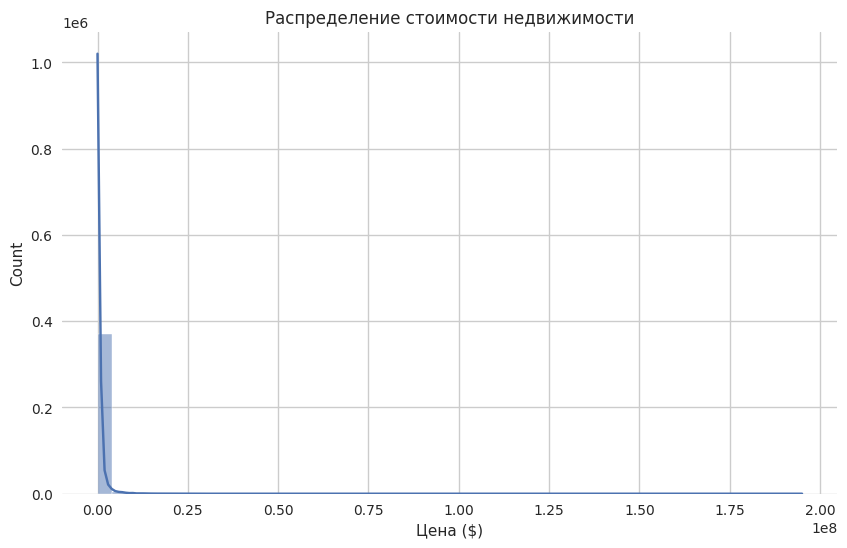

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['target_clean'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости')
plt.xlabel('Цена ($)')
plt.show()

Исходная гистограмма цен крайне неинформативна: из-за экстремальных выбросов (до $2 \times 10^8$) основное распределение "схлопнулось" в узкий пик около нуля. Чтобы избавиться от влияния этого длинного хвоста и сделать структуру данных видимой, мы применили логарифмическую трансформацию к целевой переменной



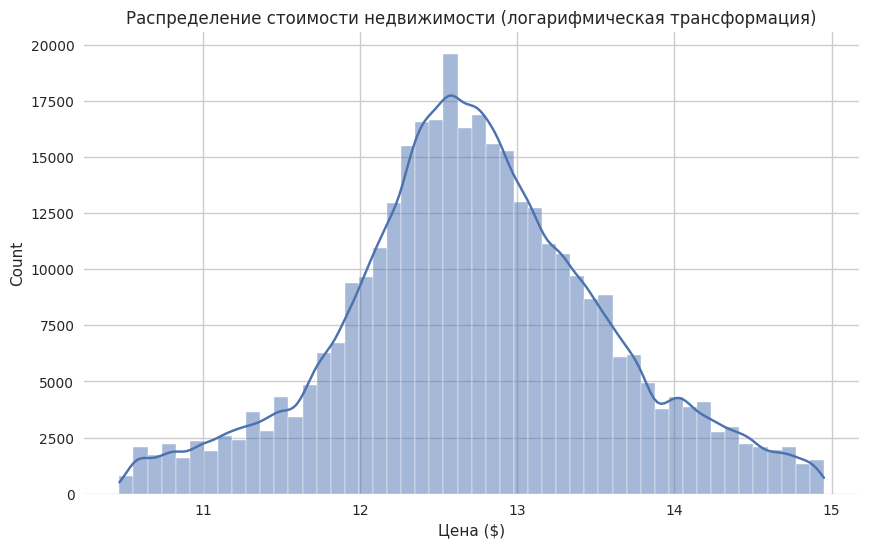

In [110]:
data['target_clean_log'] = np.log(data['target_clean'])

plt.figure(figsize=(10, 6))
sns.histplot(data['target_clean_log'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости (логарифмическая трансформация)')
plt.xlabel('Цена ($)')
plt.show()


Избавимся от выбросов по целевому признаку, для этого воспользуемся методом Тьюки, применив его к логарифмированному признаку:

In [ ]:
def find_outliers_iqr(df, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        df (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(df[feature]+1)
    else:
        x= df[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = df[(x<lower_bound) | (x > upper_bound)]
    cleaned = df[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

print(f'Тип ассиметрии до очистки: {data["target_clean_log"].skew()}')
outliers, data = find_outliers_iqr(data, 'target_clean_log')
print(f'Тип ассиметрии после очистки: {data["target_clean_log"].skew()}')

Тип ассиметрии до очистки: 0.057504414178867425
Тип ассиметрии после очистки: 0.07640701128422923


In [113]:
print(f'Число наблюдений {data.shape[0]}.')
data['target_clean'].describe()

Число наблюдений 341690.


count    3.416900e+05
mean     4.662692e+05
std      4.206970e+05
min      4.555400e+04
25%      2.090000e+05
50%      3.299000e+05
75%      5.600000e+05
max      2.549000e+06
Name: target_clean, dtype: float64

In [115]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 341690 entries, 0 to 349345
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   status            303873 non-null  object
 1   private pool      3928 non-null    object
 2   propertyType      313286 non-null  object
 3   street            341688 non-null  object
 4   baths             255635 non-null  object
 5   homeFacts         341690 non-null  object
 6   fireplace         97082 non-null   object
 7   city              341671 non-null  object
 8   schools           341690 non-null  object
 9   sqft              313877 non-null  object
 10  zipcode           341690 non-null  object
 11  beds              269994 non-null  object
 12  state             341690 non-null  object
 13  stories           215436 non-null  object
 14  mls-id            23806 non-null   object
 15  PrivatePool       36337 non-null   object
 16  MlsId             278218 non-null  object
 

После очистки датасета количество наблюдений уменьшилось до 341690, аномальные значения в виде $1 или $195 млн. были удалены. 

### Очистка числовых признаков (sqft, beds, baths)
Эти поля также содержат лишние символы.

In [48]:
# sqft
def clean_sqft(x):
    if isinstance(x, str):
        # Удаляем 'sqft' и запятые
        x = x.lower().replace('sqft', '').replace(',', '').strip()
        if '-' in x: # обработка диапазонов, берем среднее или первое
             return float('nan')
    return x

data['sqft'] = data['sqft'].apply(clean_sqft)
data['sqft'] = pd.to_numeric(data['sqft'], errors='coerce')

# beds
def clean_beds(x):
    if isinstance(x, str):
        x = x.lower().replace('beds', '').replace('bd', '').strip()
        # Можно добавить логику для '1-2 beds' и т.д.
    return x

data['beds'] = data['beds'].apply(clean_beds)
# beds чаще всего целое, но бывают float (редко)
data['beds'] = pd.to_numeric(data['beds'], errors='coerce')

# baths
def clean_baths(x):
    if isinstance(x, str):
        x = x.lower().replace('baths', '').replace('ba', '').strip()
    return x

data['baths'] = data['baths'].apply(clean_baths)
data['baths'] = pd.to_numeric(data['baths'], errors='coerce')

print("Info после очистки основных числовых полей:")
data[['sqft', 'beds', 'baths']].info()

Info после очистки основных числовых полей:
<class 'cudf.core.dataframe.DataFrame'>
Index: 374257 entries, 0 to 377184
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   sqft    310019 non-null  float64
 1   beds    263200 non-null  float64
 2   baths   230087 non-null  float64
dtypes: float64(3)
memory usage: 11.5 MB


### Анализ пропусков

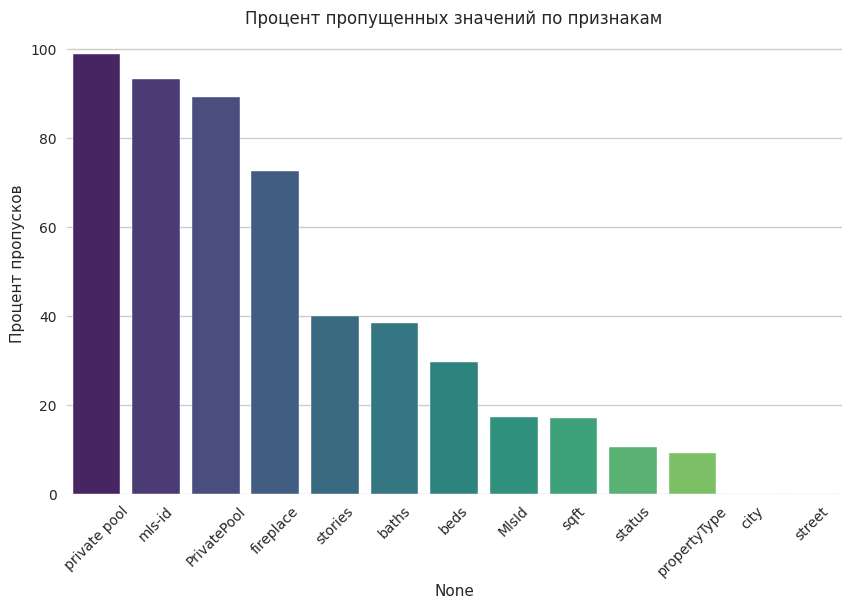

In [49]:
missing = data.isnull().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing.index, y=missing.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Процент пропущенных значений по признакам')
plt.ylabel('Процент пропусков')
plt.show()

## 2. Разведочный анализ данных (EDA)

### Распределение целевой переменной (Price)

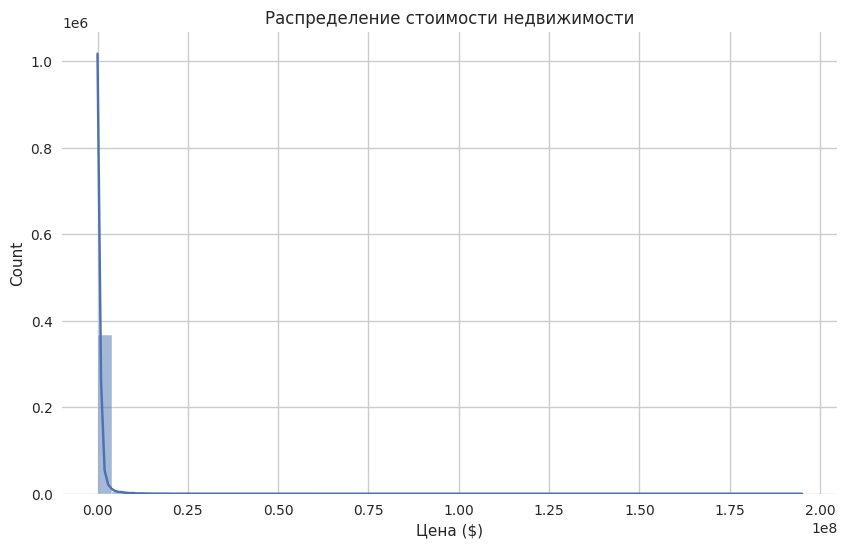

Основные статистики Price:
count    3.742570e+05
mean     6.454094e+05
std      1.842246e+06
min      1.000000e+00
25%      1.879000e+05
50%      3.200000e+05
75%      5.845000e+05
max      1.950000e+08
Name: target, dtype: float64


In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(data['target'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости')
plt.xlabel('Цена ($)')
plt.show()

print("Основные статистики Price:")
print(data['target'].describe())

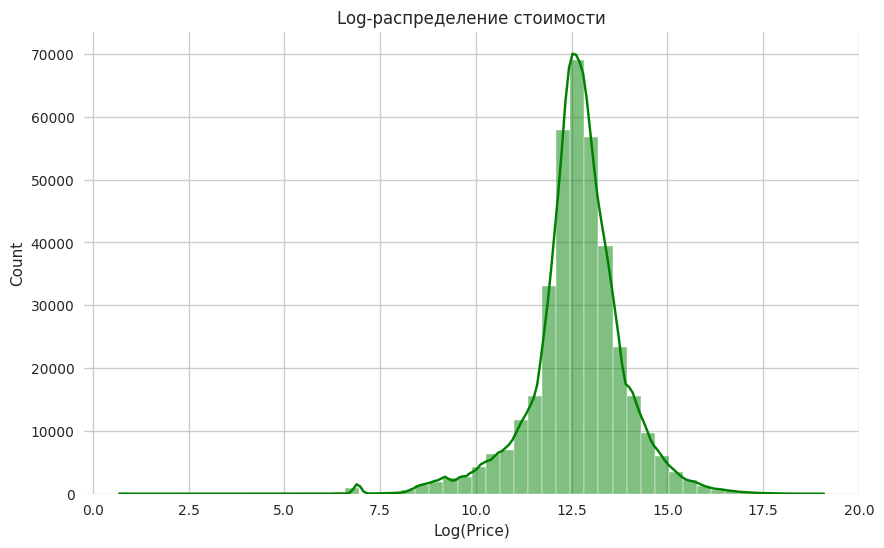

In [51]:
# Логарифмирование целевой переменной для нормализации распределения
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(data['target']), bins=50, kde=True, color='green')
plt.title('Log-распределение стоимости')
plt.xlabel('Log(Price)')
plt.show()

### Корреляционный анализ (числовые признаки)

In [52]:
print(data[['target', 'sqft', 'beds', 'baths']].dtypes)

target    float64
sqft      float64
beds      float64
baths     float64
dtype: object


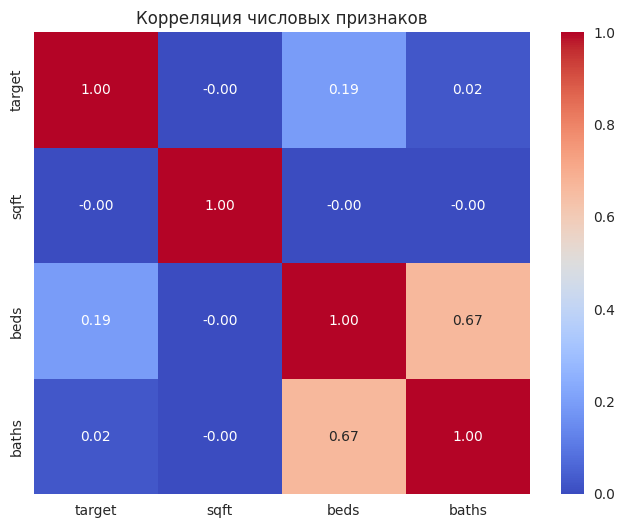

In [53]:
# Принудительно конвертируем в числа, ошибки (текст) превращаем в NaN
cols = ['target', 'sqft', 'beds', 'baths']
for col in cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Теперь считаем корреляцию
corr_matrix = data[cols].corr()

# 1. Принудительно выгружаем данные в NumPy (на CPU)
corr_array = corr_matrix.to_numpy()

plt.figure(figsize=(8, 6))

# 2. Передаем массив в Seaborn, но подписываем оси вручную
# (так как массив потерял названия колонок)
sns.heatmap(
    corr_array, 
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.index,
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f'
)

plt.title('Корреляция числовых признаков')
plt.show()

## 1.4. Анализ распределения признаков (Feature Distribution Analysis)


In [54]:
# Определение числовых и категориальных признаков
try:
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
except:
    # Fallback if using pure cudf without same api metadata sometimes
    numerical_cols = [c for c in data.columns if data[c].dtype != 'object']
    categorical_cols = [c for c in data.columns if data[c].dtype == 'object']

print(f"Числовые признаки ({len(numerical_cols)}): {numerical_cols}")
print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")


Числовые признаки (4): ['baths', 'sqft', 'beds', 'target']
Категориальные признаки (14): ['status', 'private pool', 'propertyType', 'street', 'homeFacts', 'fireplace', 'city', 'schools', 'zipcode', 'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId']


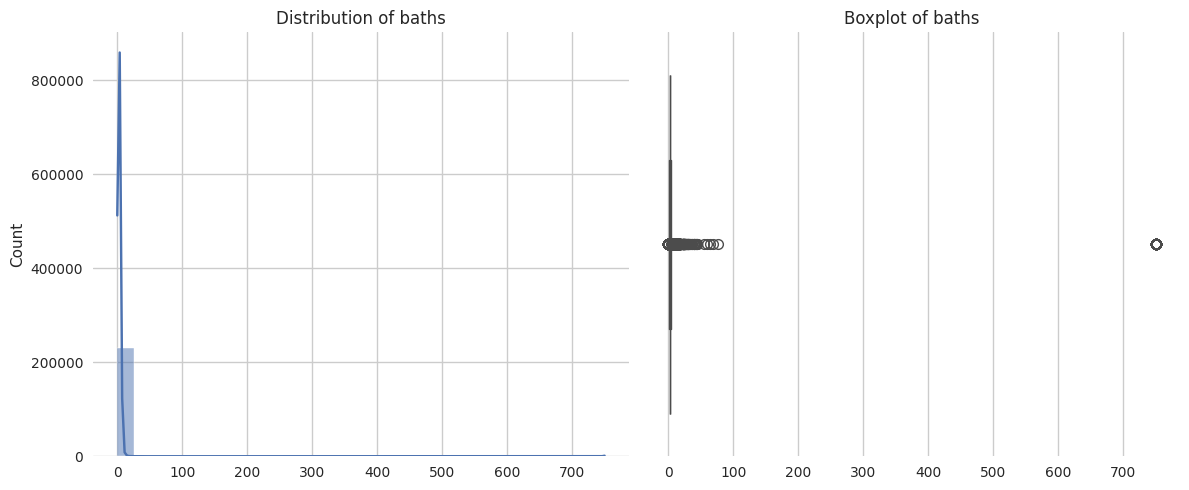

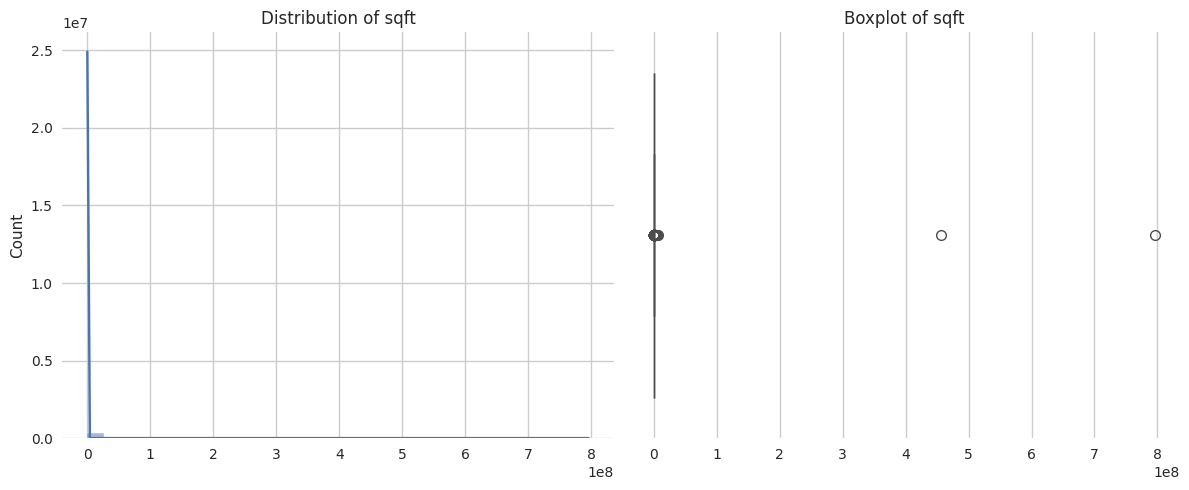

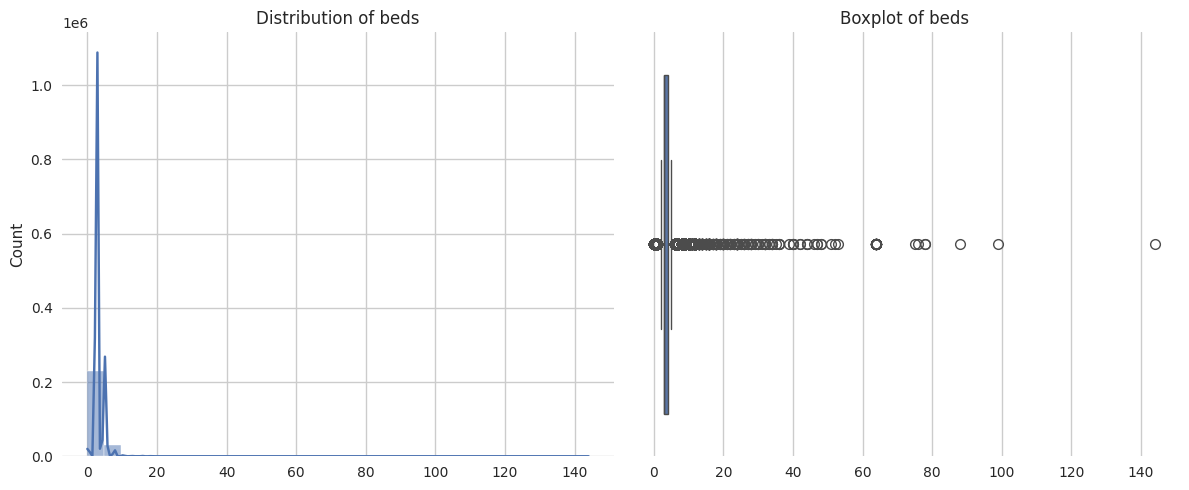

In [55]:
# Визуализация распределения числовых признаков
# Используем .to_numpy() для совместимости с seaborn/matplotlib при работе на GPU

for col in numerical_cols:
    if col == 'target': continue # Уже анализировали
    
    plt.figure(figsize=(12, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    # dropna() нужен, чтобы seaborn не ломался на NaN
    valid_data = data[col].dropna().to_numpy()
    sns.histplot(valid_data, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=valid_data)
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


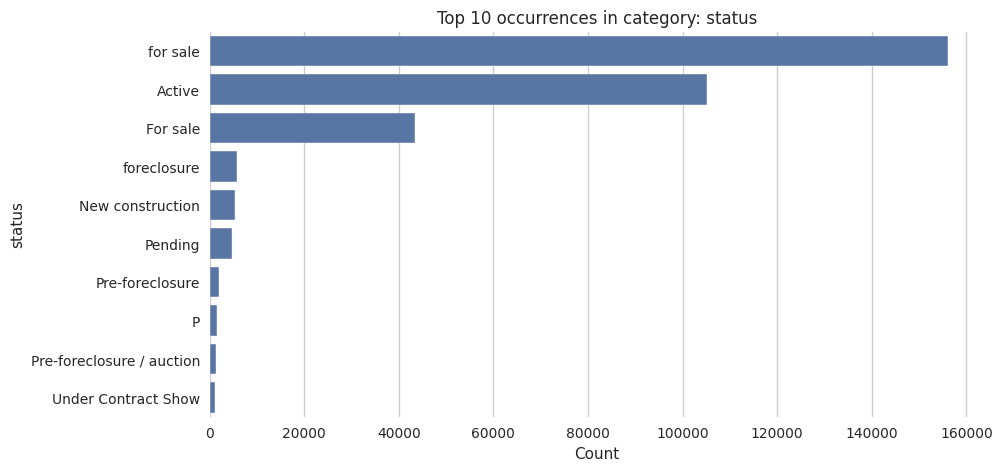

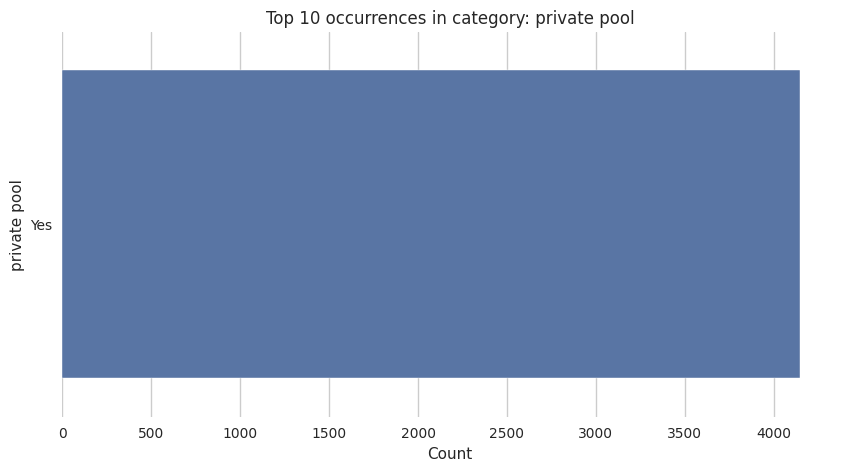

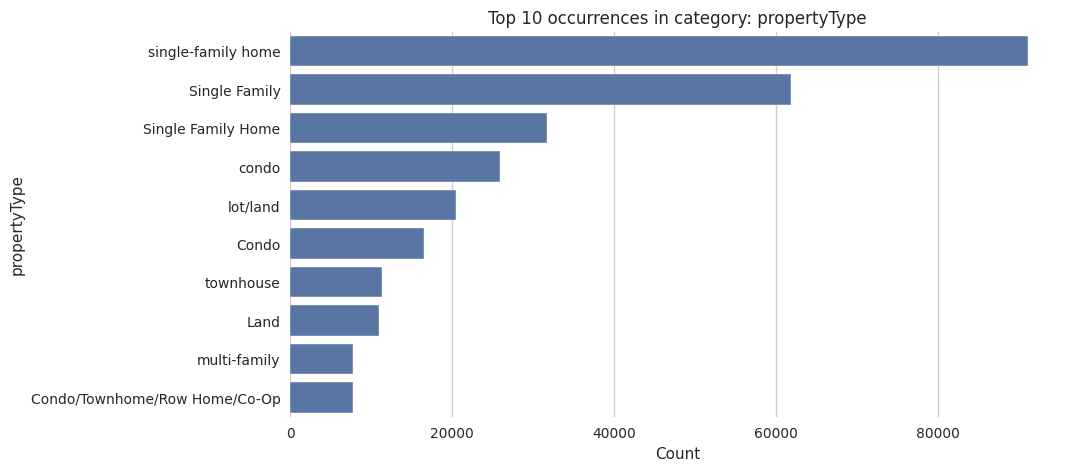

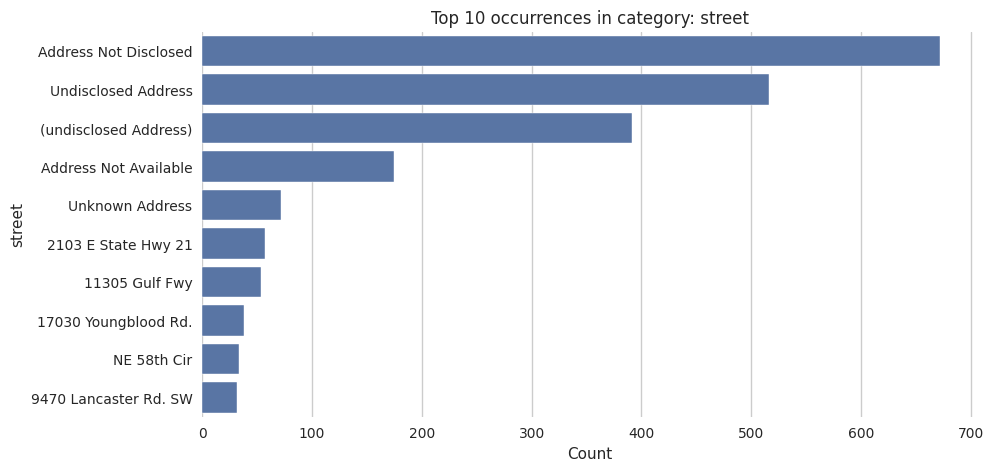

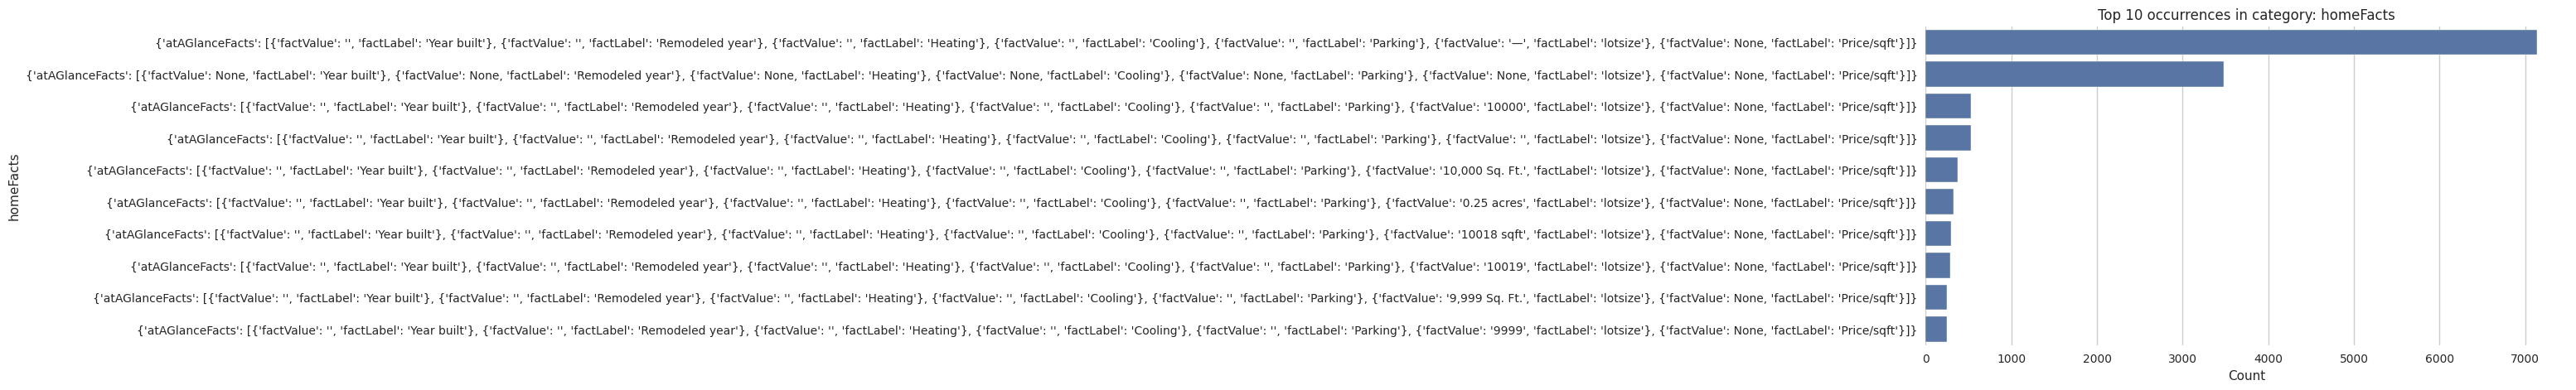

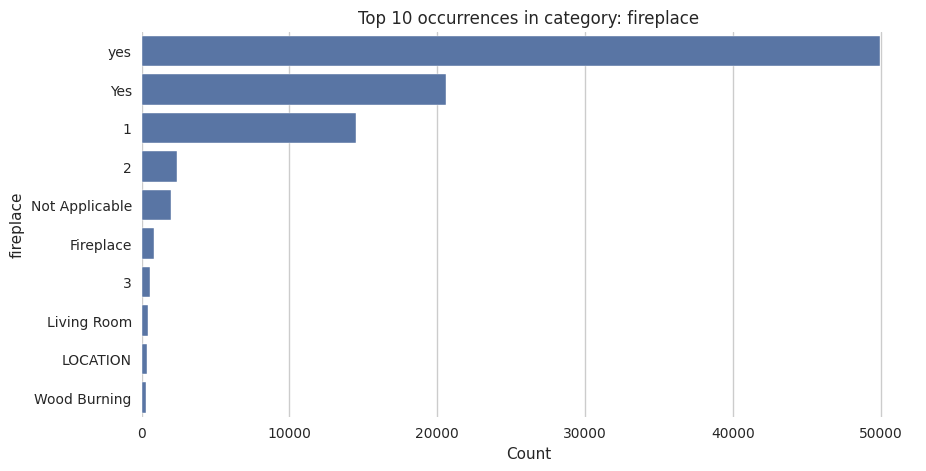

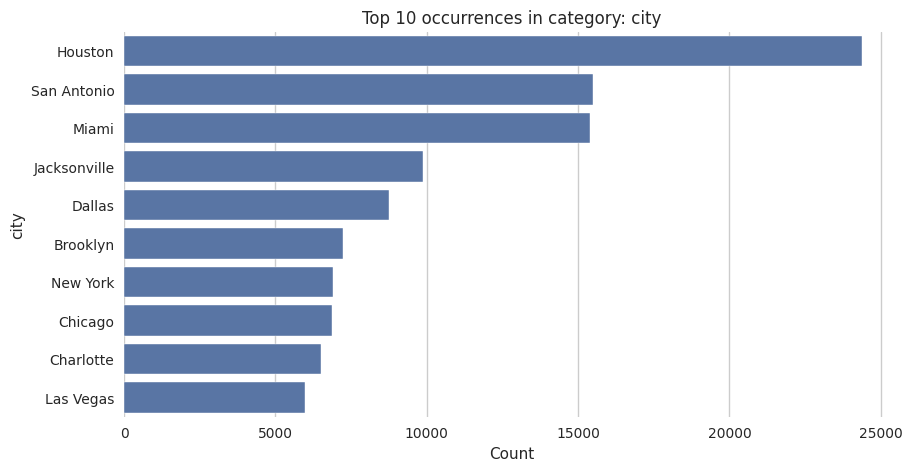

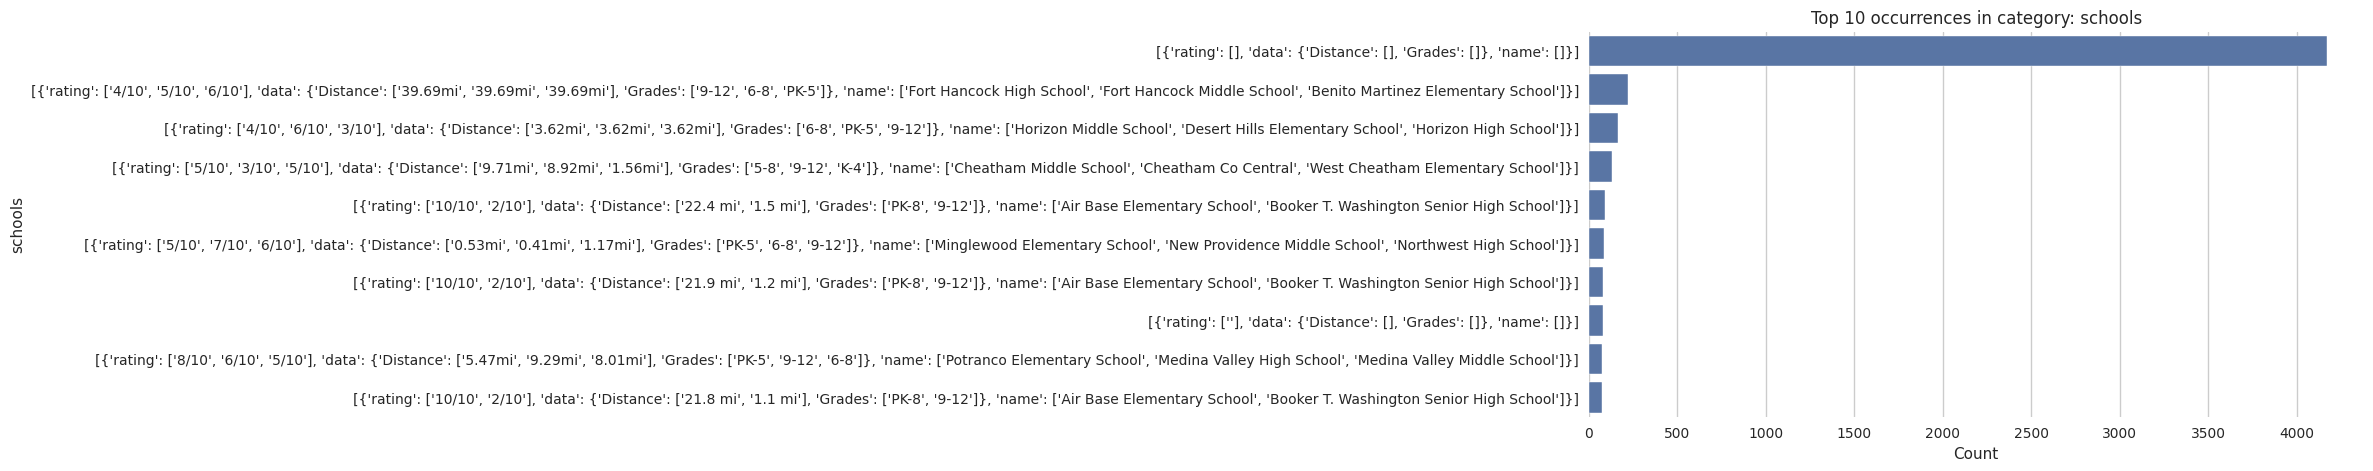

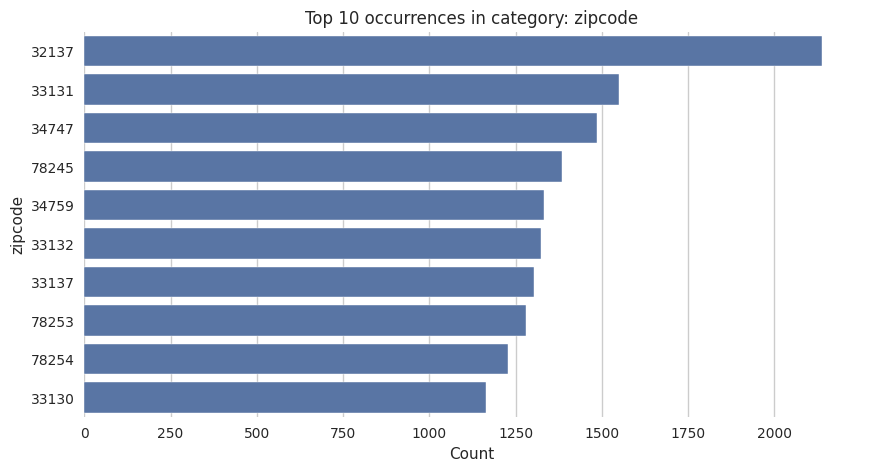

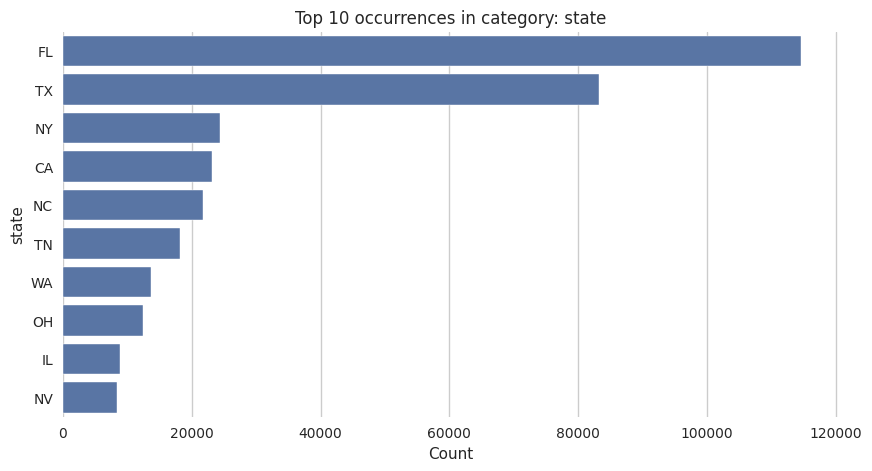

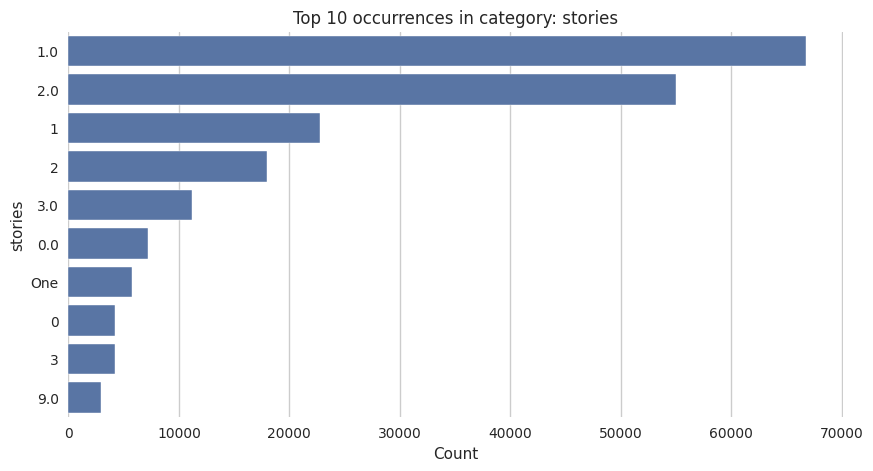

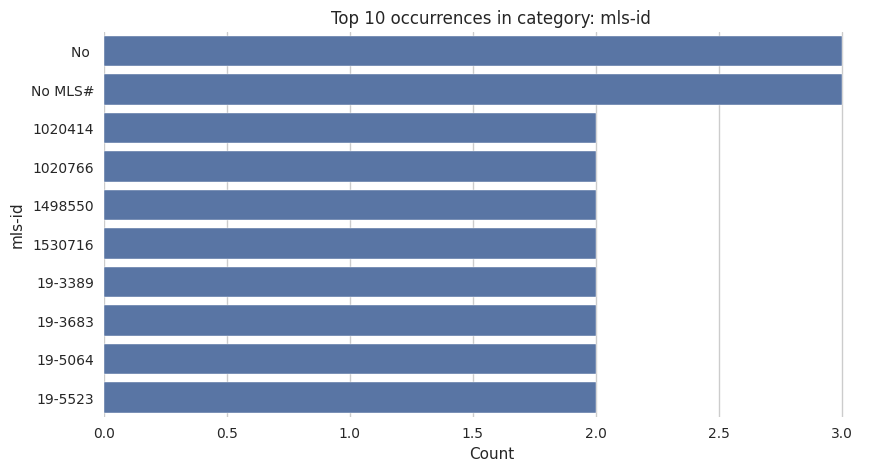

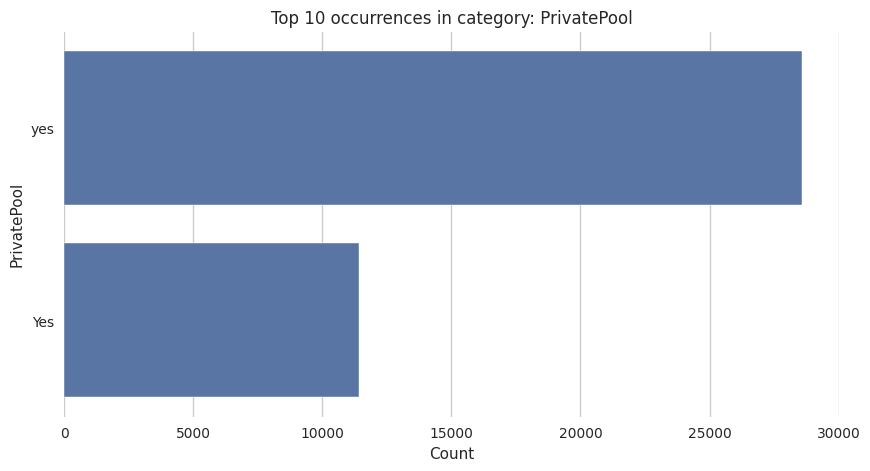

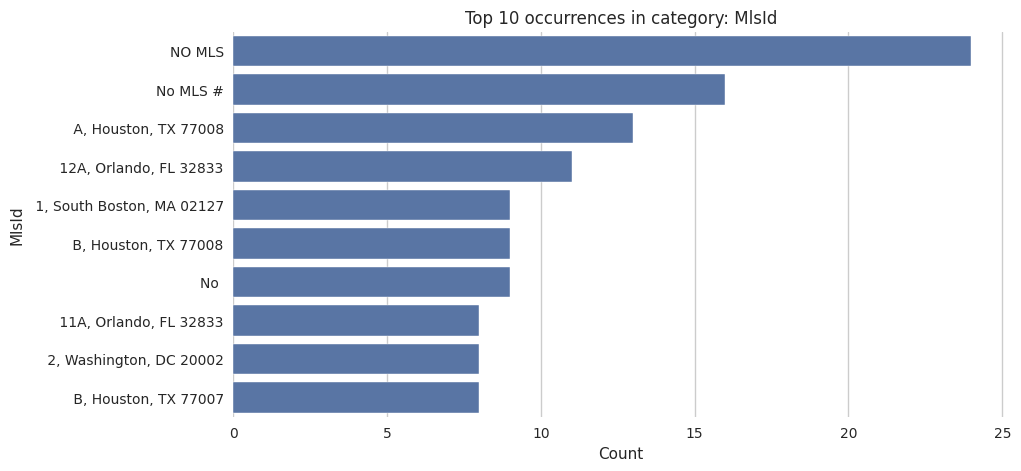

In [56]:
# Анализ топ-10 значений для категориальных признаков
for col in categorical_cols:
    if col not in data.columns: continue
    
    # Получаем топ-10 значений. 
    # value_counts() работает в cudf, но для графика конвертируем в pandas
    vc = data[col].value_counts().head(10)
    
    try:
        vc_pandas = vc.to_pandas()
    except AttributeError:
        vc_pandas = vc # Если мы уже на CPU
        
    plt.figure(figsize=(10, 5))
    sns.barplot(x=vc_pandas.values, y=vc_pandas.index)
    plt.title(f'Top 10 occurrences in category: {col}')
    plt.xlabel('Count')
    plt.show()


## 1.5. Выявление и обработка выбросов (Outlier Handling)


Размер датасета до очистки выбросов: (374257, 18)
Column target: Removing outliers outside [-407000.00, 1179400.00]
Column sqft: Removing outliers outside [-591.00, 4177.00]
Размер датасета после очистки выбросов: (270179, 18)


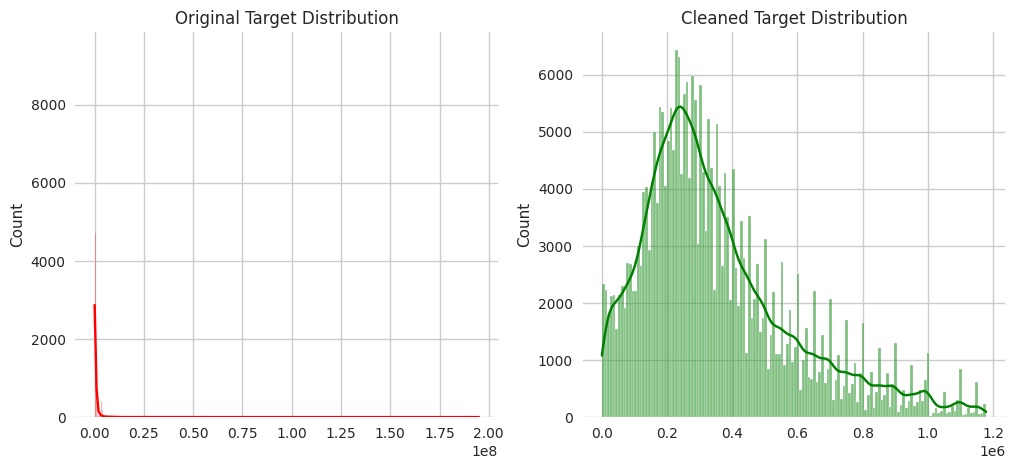

In [57]:
def remove_outliers_iqr(df, column, multiplier=1.5):
    # Вычисляем квантили
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    print(f"Column {column}: Removing outliers outside [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # Фильтрация
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Удаляем выбросы по цене (target) и площади (sqft), так как это ключевые факторы
print(f"Размер датасета до очистки выбросов: {data.shape}")

data_clean = remove_outliers_iqr(data, 'target')
data_clean = remove_outliers_iqr(data_clean, 'sqft')

print(f"Размер датасета после очистки выбросов: {data_clean.shape}")

# Сравнение распределения цены до и после
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['target'].to_numpy(), kde=True, color='red', alpha=0.3, label='Original')
plt.title('Original Target Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data_clean['target'].to_numpy(), kde=True, color='green', alpha=0.5, label='Cleaned')
plt.title('Cleaned Target Distribution')
plt.show()

# Сохраняем очищенные данные в переменную data для дальнейшей работы
# data = data_clean # Раскомментируйте, если готовы применить изменения глобально


## 1.6. Статистические тесты (Hypothesis Testing)


In [58]:
# Проверка гипотезы: Зависит ли стоимость недвижимости (target) от количества спален (beds)?
# Используем критерий Краскела-Уоллиса, так как распределение цены, скорее всего, ненормальное.

from scipy import stats

try:
    unique_beds = sorted(data['beds'].unique().to_numpy())
except:
    unique_beds = sorted(data['beds'].unique()) # Если pandas

beds_groups = []
labels = []

for b in unique_beds:
    # Выбираем цены для каждого количества спален
    group = data[data['beds'] == b]['target'].dropna()
    try:
        group = group.to_numpy()
    except:
        pass
    
    # Берем группы, где хотя бы 50 записей, для надежности
    if len(group) > 50:
        beds_groups.append(group)
        labels.append(b)

if len(beds_groups) > 1:
    stat, p_value = stats.kruskal(*beds_groups)
    print(f"Kruskal-Wallis для зависимости Цены от Спален (beds): Statistic={stat:.2f}, p-value={p_value:.4e}")

    alpha = 0.05
    if p_value < alpha:
        print("Результат: Отвергаем H0. Существует статистически значимая разница в стоимости квартир с разным количеством спален.")
    else:
        print("Результат: Не отвергаем H0. Разница не статистически значима.")
else:
    print("Недостаточно групп для проведения теста.")


Kruskal-Wallis для зависимости Цены от Спален (beds): Statistic=33158.75, p-value=0.0000e+00
Результат: Отвергаем H0. Существует статистически значимая разница в стоимости квартир с разным количеством спален.


## 1.7. Анализ сложных признаков (homeFacts и schools)


In [59]:
# Парсинг сложных колонок 'homeFacts' и 'schools'
import ast
import re

# 1. Парсинг homeFacts
def parse_homeFacts(val):
    if pd.isna(val): return {}
    try:
        # Строка выглядит как словарь Python
        d = ast.literal_eval(val)
        facts = d.get('atAGlanceFacts', [])
        result = {}
        for fact in facts:
            label = fact.get('factLabel', '')
            value = fact.get('factValue', '')
            if label and value:
                result[label] = value
        return result
    except:
        return {}

# 2. Парсинг schools
def parse_schools(val):
    if pd.isna(val): return {'avg_rating': None, 'min_dist': None}
    try:
        # Строка выглядит как список с одним словарем
        l = ast.literal_eval(val)
        if not l or not isinstance(l, list): return {'avg_rating': None, 'min_dist': None}
        d = l[0]
        
        ratings = d.get('rating', [])
        distances = d.get('data', {}).get('Distance', [])
        
        # Обработка рейтингов
        valid_ratings = []
        for r in ratings:
            try:
                # Рейтинги могут быть 'NR', 'NA' или числами
                if r and r not in ['NR', 'NA', 'None', '']:
                    # Иногда рейтинг 'X/10', берем первую часть
                    r_clean = r.split('/')[0]
                    valid_ratings.append(float(r_clean))
            except:
                pass
        
        avg_rating = sum(valid_ratings) / len(valid_ratings) if valid_ratings else None
        
        # Обработка дистанций
        valid_dists = []
        for dist in distances:
            try:
                # Дистанция '2.7 mi'
                if dist:
                    d_clean = re.findall(r"\d+\.?\d*", dist)
                    if d_clean:
                        valid_dists.append(float(d_clean[0]))
            except:
                pass
                
        min_dist = min(valid_dists) if valid_dists else None
        
        return {'schools_avg_rating': avg_rating, 'schools_min_dist': min_dist}
    except:
        return {'schools_avg_rating': None, 'schools_min_dist': None}

print("Функции парсинга определены.")


Функции парсинга определены.


In [60]:
# Применяем парсинг. NB: Это медленная операция, так как выполняется на CPU с помощью apply.
# Для ускорения можно использовать multiprocessing, но в ноутбуке это сложнее.
print("Начинаем извлечение признаков... Это может занять время.")

# Работаем с копией в pandas для безопасности и совместимости
try:
    df_pandas = data.to_pandas()
except:
    df_pandas = data # Уже pandas

# --- Extract homeFacts ---
# Извлечем нужные поля: Year built, Remodeled year, Heating, Cooling, Parking, lotsize
# Сначала применим парсинг ко всему столбцу
home_facts_parsed = df_pandas['homeFacts'].apply(parse_homeFacts)

# Создаем DataFrame из списка словарей
home_facts_df = pd.json_normalize(home_facts_parsed)

# Выбираем и переименовываем интересные колонки
cols_of_interest = {
    'Year built': 'year_built',
    'Remodeled year': 'remodeled_year',
    'Heating': 'heating',
    'Cooling': 'cooling',
    'Parking': 'parking',
    'lotsize': 'lotsize_raw'
}
# Берем только существующие колонки
available_cols = [c for c in cols_of_interest.keys() if c in home_facts_df.columns]
home_facts_df = home_facts_df[available_cols].rename(columns=cols_of_interest)

# --- Extract schools ---
schools_parsed = df_pandas['schools'].apply(parse_schools)
schools_df = pd.json_normalize(schools_parsed)

# Объединяем с основным датафреймом
df_pandas = pd.concat([df_pandas, home_facts_df, schools_df], axis=1)

print("Извлечение завершено. Новые колонки:", home_facts_df.columns.tolist() + schools_df.columns.tolist())

# Конвертация 'year_built' в число
df_pandas['year_built'] = pd.to_numeric(df_pandas['year_built'], errors='coerce')

# Возвращаем в main data переменную (если используем cudf, конвертируем обратно)
if USE_GPU:
    import cudf
    # cudf может не поддерживать object колонки со сложными типами, поэтому будьте осторожны
    # data = cudf.DataFrame(df_pandas) # Это может быть тяжело по памяти
    # Лучше пока оставим в pandas для EDA этих колонок или обновим только нужные
    pass
else:
    data = df_pandas

# Посмотрим на корреляцию новых числовых признаков с таргетом
new_numeric_cols = ['year_built', 'schools_avg_rating', 'schools_min_dist', 'target']
corr_new = df_pandas[new_numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_new, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция новых признаков с Ценой')
plt.show()


Начинаем извлечение признаков... Это может занять время.
Извлечение завершено. Новые колонки: ['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize_raw', 'schools_avg_rating', 'schools_min_dist']


TypeError: Wrong type ((<class 'numpy.object_'>,)) of arguments for cupy_copy

<Figure size 800x600 with 0 Axes>

In [ ]:
# FIX: Создание недостающих колонок для совместимости со старым кодом
print("Восстановление колонок 'target_clean' и 'target_clean_log'...")

try:
    # Убедимся, что target числовой
    data['target'] = pd.to_numeric(data['target'], errors='coerce')
    
    # Восстанавливаем target_clean как копию target
    if 'target_clean' not in data.columns:
        data['target_clean'] = data['target']
        print("Колонка 'target_clean' создана.")
    
    # Восстанавливаем target_clean_log
    if 'target_clean_log' not in data.columns:
        # Используем numpy (работает и с pandas и с cudf, если импортирован как np)
        # Добавим обработку нулей/отрицательных, если есть (хотя цена > 0)
        data['target_clean_log'] = np.log(data['target_clean'])
        print("Колонка 'target_clean_log' создана.")
        
    print("Готово. Теперь можно запускать ячейки, использующие эти колонки.")
    
except Exception as e:
    print(f"Ошибка при восстановлении колонок: {e}")


## 1.4. Очистка и анализ признаков sqft, beds, baths

Приведем признаки `sqft`, `beds`, `baths` к числовому виду, удалив лишние символы и обработав пропуски/аномалии.


In [ ]:
# Функция для очистки sqft
def clean_sqft(x):
    if isinstance(x, str):
        # Удаляем 'sqft' и запятые
        x = x.lower().replace('sqft', '').replace(',', '').strip()
        if '-' in x: # обработка диапазонов (например, '1000-1200'), возвращаем NaN для простоты
             return None
        if not x.replace('.', '', 1).isdigit(): # Если не число после очистки
             return None
    return x

# Функция для очистки beds
def clean_beds(x):
    if isinstance(x, str):
        x = x.lower().replace('beds', '').replace('bd', '').replace('bed', '').strip()
        # Обработка странных значений типа '1-2 beds' или текстовых описаний
        if not x.replace('.', '', 1).isdigit():
            return None
    return x

# Функция для очистки baths
def clean_baths(x):
    if isinstance(x, str):
        x = x.lower().replace('baths', '').replace('ba', '').replace('bath', '').strip()
        if not x.replace('.', '', 1).isdigit():
            return None
    return x

# Применяем очистку
data['sqft_clean'] = data['sqft'].apply(clean_sqft).astype(float)
data['beds_clean'] = data['beds'].apply(clean_beds).astype(float)
data['baths_clean'] = data['baths'].apply(clean_baths).astype(float)

# Удаляем старые колонки или оставляем для сравнения? Пока оставим, но работать будем с clean.
print("Пропуски после очистки:")
print(data[['sqft_clean', 'beds_clean', 'baths_clean']].isnull().sum())

# Посмотрим на статистику
print(data[['sqft_clean', 'beds_clean', 'baths_clean']].describe())


### Анализ распределения площади (sqft)
Посмотрим на гистограмму и boxplot для `sqft_clean`.


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['sqft_clean'].dropna(), bins=50, kde=True)
plt.title('Распределение sqft')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['sqft_clean'].dropna())
plt.title('Boxplot sqft')
plt.show()


**Вывод**:
Распределение площади имеет длинный правый хвост (log-normal подобное).
Наблюдаются значительные выбросы в большую сторону, которые могут исказить модель.
Необходимо будет рассмотреть удаление выбросов или логарифмирование.


### Анализ количества спален (beds) и ванных (baths)
Это дискретные, но числовые признаки.


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x=data['beds_clean'].dropna(), ax=ax[0], order=sorted(data['beds_clean'].dropna().unique())[:15])
ax[0].set_title('Top 15 значений Beds')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.countplot(x=data['baths_clean'].dropna(), ax=ax[1], order=sorted(data['baths_clean'].dropna().unique())[:15])
ax[1].set_title('Top 15 значений Baths')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


**Вывод**:
Большинство домов имеют от 1 до 5 спален.
Есть дробные значения для ванных комнат (например, 2.5), что нормально для США (туалет без душа).
Присутствуют аномально большие значения (выбросы), которые стоит проверить.


### Корреляция с целевой переменной
Построим матрицу корреляций для очищенных числовых признаков.


In [ ]:
corr_cols = ['target_clean', 'sqft_clean', 'beds_clean', 'baths_clean']
corr_matrix = data[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция: Price vs Sqft, Beds, Baths')
plt.show()


**Вывод**:
Наибольшую корреляцию с ценой имеет площадь (`sqft_clean`).
`beds` и `baths` также положительно коррелируют с ценой и между собой (мультиколлинеарность).
Это подтверждает важность этих признаков для модели.
